# 一、环境设置
本示例基于飞桨开源框架2.0版本。

In [1]:
import paddle
from paddle.nn import Conv2D, Linear, Embedding
from paddle import to_tensor
import paddle.nn.functional as F
import os, zipfile
import io, random, json
import numpy as np
import matplotlib.pyplot as plt
print(paddle.__version__)



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

2.0.2


In [2]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
import paddle.nn as nn

print(paddle.__version__)  # 查看当前版本

# cpu/gpu环境选择，在 paddle.set_device() 输入对应运行设备。
device = paddle.set_device('gpu')

2.0.2


# 二、数据准备

（1）解压数据，读取并解析数据，生成all_data.txt

（2）生成数据字典，即dict.txt

（3）生成数据列表，并进行训练集与验证集的划分，train_list.txt 、eval_list.txt

（4）定义训练数据集提供器

In [3]:

#解压原始数据集，将Rumor_Dataset.zip解压至data目录下
src_path="data/data20519/Rumor_Dataset.zip"
target_path="/home/aistudio/data/Chinese_Rumor_Dataset-master"
if(not os.path.isdir(target_path)):
    z = zipfile.ZipFile(src_path, 'r')
    z.extractall(path=target_path)
    z.close()





In [4]:


#数据文件路径
rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/rumor-repost/")

non_rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/non-rumor-repost/")
original_microblog = target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"

rumor_label="0"
non_rumor_label="1"


rumor_num = 0
non_rumor_num = 0
all_rumor_list = []
all_non_rumor_list = []

#解析数据
for rumor_class_dir in rumor_class_dirs: 
    if(rumor_class_dir != '.DS_Store'):
        #遍历数据，并解析
        with open(original_microblog + rumor_class_dir, 'r') as f:
	        rumor_content = f.read()
        rumor_dict = json.loads(rumor_content)
        all_rumor_list.append(rumor_label+"\t"+rumor_dict["text"]+"\n")
        rumor_num +=1

#解析数据
for non_rumor_class_dir in non_rumor_class_dirs: 
    if(non_rumor_class_dir != '.DS_Store'):
        with open(original_microblog + non_rumor_class_dir, 'r') as f2:
	        non_rumor_content = f2.read()
        non_rumor_dict = json.loads(non_rumor_content)
        all_non_rumor_list.append(non_rumor_label+"\t"+non_rumor_dict["text"]+"\n")
        non_rumor_num +=1
        

In [5]:
#全部数据进行乱序后写入all_data.txt

data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_data.txt"

all_data_list = all_rumor_list + all_non_rumor_list

random.shuffle(all_data_list)

#在生成all_data.txt之前，首先将其清空
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(all_data_path, 'a') as f:
    for data in all_data_list:
        f.write(data) 

In [6]:
# 生成数据字典
def create_dict(data_path, dict_path):
    with open(dict_path, 'w') as f:
        f.seek(0)
        f.truncate() 

    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '')
        for s in content:
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    end_dict = {"<pad>": i+1}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
        
    print("数据字典生成完成！")


In [33]:
# 创建序列化表示的数据,并按照一定比例划分训练数据train_list.txt与验证数据eval_list.txt
def load_vocab(file_path):
    fr = open(file_path, 'r', encoding='utf8')
    vocab = eval(fr.read())   #读取的str转换为字典
    fr.close()

    return vocab

def f_write_txt(words, dict_txt, label):
    labs = ""
    for s in words:
        lab = str(dict_txt[s])
        labs = labs + lab + ','
    labs = labs[:-1]
    labs = labs + '\t' + label + '\n'
    return labs

def create_data_list(data_path, train_path, test_path, dict_path):
    
    dict_txt = load_vocab(dict_path)
    with open(data_path, 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()

    i = 0
    maxlen = 0
    with open(test_path, 'a', encoding='utf-8') as f_eval,open(train_path, 'a', encoding='utf-8') as f_train:
        for line in lines:
            words = line.split('\t')[-1].replace('\n', '')
            maxlen = max(maxlen, len(words))
            label = line.split('\t')[0]
            labs = f_write_txt(words, dict_txt, label)
            # 每8个 抽取一个数据用于验证
            if i % 7 == 0:
                f_eval.write(labs)
            else:
                f_train.write(labs)
            i += 1
    print("数据列表生成完成！")
    print(maxlen)




In [34]:
# 把生成的数据列表都放在自己的总类别文件夹中
data_root_path = "/home/aistudio/data/" 
data_path = os.path.join(data_root_path, 'all_data.txt')
train_path = os.path.join(data_list_path, 'train_list.txt')
test_path = os.path.join(data_list_path, 'eval_list.txt')
dict_path = os.path.join(data_root_path, "dict.txt")

# 创建数据字典
create_dict(data_path, dict_path)

# 创建数据列表

#在生成数据之前，首先将eval_list.txt和train_list.txt清空
with open(test_path, 'w', encoding='utf-8') as f_eval:
    f_eval.seek(0)
    f_eval.truncate()
with open(train_path, 'w', encoding='utf-8') as f_train:
    f_train.seek(0)
    f_train.truncate() 

create_data_list(data_path, train_path, test_path, dict_path)



数据字典生成完成！
数据列表生成完成！
226


In [35]:
# 打印前2条训练数据
vocab = load_vocab(dict_path)

def ids_to_str(ids):
    words = []
    for k in ids:
        w = list(vocab.keys())[list(vocab.values()).index(int(k))]
        words.append(w if isinstance(w, str) else w.decode('ASCII'))
    return " ".join(words)

with io.open(train_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            print(str(i)+":")
            print('sentence list id is:', wids)
            print('sentence list is: ', ids_to_str(wids))
            print('sentence label id is:', label)
            print('---------------------------------')
            
            if i == 2: break




1:
sentence list id is: ['3838', '1416', '2496', '3108', '1505', '1421', '3326', '1155', '1458', '1035', '101', '1581', '4285', '811', '1526', '1477', '4197', '3173', '1376', '2302', '1439', '4042', '2959', '1424', '1843', '1843', '3461', '415', '1747', '1747', '1843', '2546', '3395', '3628', '1747', '4273', '4134', '2853', '3395', '572', '70', '2853', '2959', '1026', '1416', '2674', '2551', '4088', '1787', '4248', '1264', '639', '2267', '3312', '2691', '4350', '3739', '1377', '1035', '101', '1581', '4285', '2914', '1416', '2674', '1505', '1421', '4133', '43', '218', '1081', '198', '218', '3389', '3937', '584', '2131', '2266', '3959', '2131', '965', '3014', '3312', '1416', '2674', '1505', '2448', '4289', '3406', '975', '1614', '177', '2095', '3538', '2104', '261', '4133', '2691', '1512', '1420', '4108', '2973', '797', '3612', '3312', '3289', '1978', '4108', '797', '3612', '441', '811', '3668', '3103', '3076', '1505', '1421', '4133', '3326', '1155', '1458', '1416', '2674', '3389', '971'

In [36]:



class RumorDataset(paddle.io.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.all_data = []
       
        with io.open(self.data_dir, "r", encoding='utf8') as fin:
            for line in fin:
                cols = line.strip().split("\t")
                if len(cols) != 2:
                    sys.stderr.write("[NOTICE] Error Format Line!")
                    continue
                label = []
                label.append(int(cols[1]))
                wids = cols[0].split(",")
                if len(wids)>=150:
                    wids = np.array(wids[:150]).astype('int64')     
                else:
                    wids = np.concatenate([wids, [vocab["<pad>"]]*(150-len(wids))]).astype('int64')
                label = np.array(label).astype('int64')
                self.all_data.append((wids, label))

        
    def __getitem__(self, index):
        data, label = self.all_data[index]
        return data, label

    def __len__(self):
        return len(self.all_data)


batch_size = 32
train_dataset = RumorDataset(train_path)
test_dataset = RumorDataset(test_path)

train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)




#check

print('=============train_dataset =============') 
for data, label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break


print('=============test_dataset =============') 
for data, label in test_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break




=============train_dataset =============
[3838 1416 2496 3108 1505 1421 3326 1155 1458 1035  101 1581 4285  811
 1526 1477 4197 3173 1376 2302 1439 4042 2959 1424 1843 1843 3461  415
 1747 1747 1843 2546 3395 3628 1747 4273 4134 2853 3395  572   70 2853
 2959 1026 1416 2674 2551 4088 1787 4248 1264  639 2267 3312 2691 4350
 3739 1377 1035  101 1581 4285 2914 1416 2674 1505 1421 4133   43  218
 1081  198  218 3389 3937  584 2131 2266 3959 2131  965 3014 3312 1416
 2674 1505 2448 4289 3406  975 1614  177 2095 3538 2104  261 4133 2691
 1512 1420 4108 2973  797 3612 3312 3289 1978 4108  797 3612  441  811
 3668 3103 3076 1505 1421 4133 3326 1155 1458 1416 2674 3389  971 2266
 2790 4197 3312 2019 1233 3076 1477 4197 3173 1376 1505 1421 2302 1439
 2501 4410 4410 4410 4410 4410 4410 4410 4410 4410]
(150,)
[1]
=============test_dataset =============
[3838  197 2496 3554 2551  867 2416 2514 1843 3602  937   70 1264  811
 1614 3890  724 1341 2959 2164  365  513 4406  723 1240 4042 3912  426
 112

In [11]:
batch_size = 32
epochs = 3

#词汇表总数
vocab_size = len(vocab) + 1
print(vocab_size)


emb_size = 256
#句子固定长度
seq_len = 150



#补齐词的id编号
pad_id = vocab["<pad>"]

#类别
classes = ['negative', 'positive']

4412


In [12]:
import paddle.nn as nn
import paddle

# 定义GRU网络
class MyGRU(paddle.nn.Layer):
    def __init__(self):
        super(MyGRU, self).__init__()

        #将词汇表中的每个词映射为256维向量，以避免one-hot编码带来的稀疏性
        self.embedding = nn.Embedding(vocab_size, emb_size)

        #定义模型
        # 这里的input_size就是词向量的维度，hidden_size就是RNN隐藏层的维度
        # 并不需要指定时间步数，也即seq_len，这是因为，GRU和LSTM都实现了自身的迭代
        self.gru = nn.GRU(input_size=emb_size, hidden_size=256, num_layers=2, direction='bidirectional',dropout=0.5)
        self.linear = nn.Linear(in_features=256*2, out_features=2)  #二分类问题，情感分为积极和消极
        self.dropout = nn.Dropout(p=0.5)
    

    def forward(self, inputs):
        
        #词嵌入
        #inputs大小为句子长度*embedding向量大小=200*256
        #emb大小为 [32, 200, 256]
        emb = self.dropout(self.embedding(inputs))

        #调用gru        
        output, hidden = self.gru(emb)
        #output形状大小为[32, 200, 512]=[batch_size,seq_len,num_directions * hidden_size]
        #hidden形状大小为[4, 32, 256]=[num_layers * num_directions, batch_size, hidden_size]

        #把前向的hidden与后向的hidden（大小为[32, 256]）合并在一起，对axis=1进行运算
        hidden = paddle.concat((hidden[-2,:,:], hidden[-1,:,:]), axis = 1)
        #合并后，hidden形状大小为[32, 512]=[batch_size, hidden_size * num_directions]        

        hidden = self.dropout(hidden)
        return self.linear(hidden)

In [13]:
# 可视化定义
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


epoch: 0, batch_id: 0, loss is: [0.7221323]
epoch: 0, batch_id: 9, loss is: [0.6840248]
epoch: 0, batch_id: 18, loss is: [0.6523112]
epoch: 0, batch_id: 27, loss is: [0.72411]
epoch: 0, batch_id: 36, loss is: [0.6675221]
epoch: 0, batch_id: 45, loss is: [0.6484275]
epoch: 0, batch_id: 54, loss is: [0.9082935]
epoch: 0, batch_id: 63, loss is: [0.5325916]
epoch: 0, batch_id: 72, loss is: [0.74838877]
epoch: 0, batch_id: 81, loss is: [0.52809227]
[validation] accuracy: 0.7458333373069763, loss: 0.4981584846973419
epoch: 1, batch_id: 0, loss is: [0.3233896]
epoch: 1, batch_id: 9, loss is: [0.54009837]
epoch: 1, batch_id: 18, loss is: [0.48239464]
epoch: 1, batch_id: 27, loss is: [0.48002735]
epoch: 1, batch_id: 36, loss is: [0.22664317]
epoch: 1, batch_id: 45, loss is: [0.21682525]
epoch: 1, batch_id: 54, loss is: [0.36752892]
epoch: 1, batch_id: 63, loss is: [0.42825824]
epoch: 1, batch_id: 72, loss is: [0.45319408]
epoch: 1, batch_id: 81, loss is: [0.3583773]
[validation] accuracy: 0.837

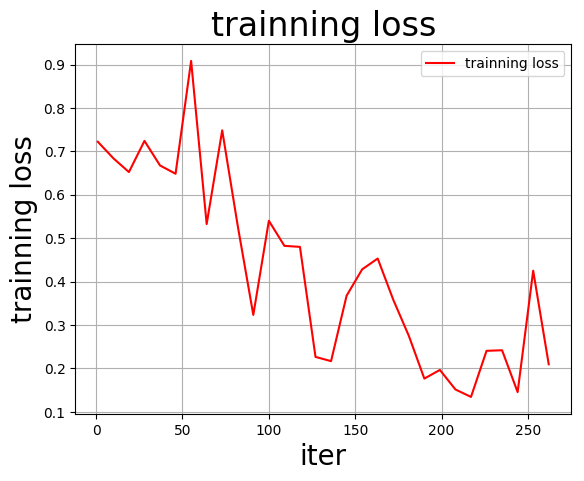

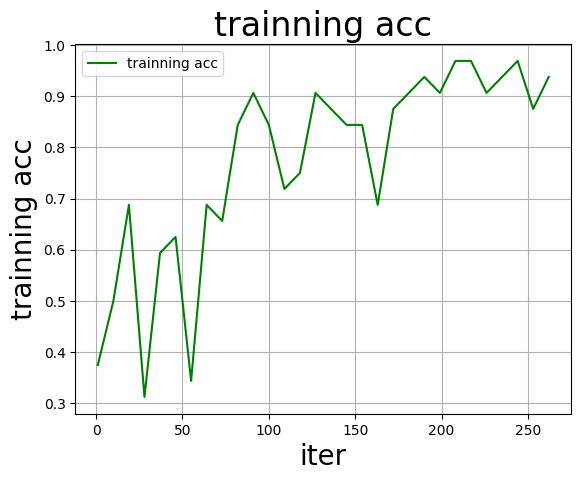

13.013412714004517


In [37]:
# 对模型进行封装
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    steps = 0
    

    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            #每次送入一个batch的数据,sent大小为[32, 200]
            sent = data[0]
            label = data[1]            
            #送入模型            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 9 == 0:  # 500个epoch输出一次结果
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

        # 保存模型
    paddle.save(model.state_dict(),"gru_model_final.pdparams")
    
    # 可视化查看
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

Iters, total_loss, total_acc = [], [], []
import time
a = time.time()    
model = MyGRU()
train(model)
b = time.time()
print(b-a)

In [24]:
f1 = open("loss.txt","w")
for line in total_loss:
    f1.write(str(line)+"\n")
f1.close()

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
model_state_dict = paddle.load('gru_model_final.pdparams')
model = MyGRU()
model.set_state_dict(model_state_dict) 
model.eval()
predictions = []
r = []
for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    gt_labels = data[1].numpy()
    for i in gt_labels:
        r.append(i)
    results = model(sent)
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        predictions.append(idx)
    
confusion_matrix(r, predictions)
from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


              precision    recall  f1-score   support

           0     0.8026    0.8423    0.8220       222
           1     0.8583    0.8217    0.8396       258

    accuracy                         0.8313       480
   macro avg     0.8304    0.8320    0.8308       480
weighted avg     0.8325    0.8313    0.8315       480

